In [16]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
def gaussian_data(mus, covmats, n):
    g1 = np.random.multivariate_normal(mus[0], covmats[0], int(n / 2))
    y1 = np.ones((int(n / 2), 1))
    xy1 = np.concatenate((g1, y1), axis=1)
    g2 = np.random.multivariate_normal(mus[1], covmats[1], int((n + 1) / 2))
    y2 = - np.ones((int((n + 1) / 2), 1))
    xy2 = np.concatenate((g2, y2), axis=1)
    xy = np.concatenate((xy1, xy2), axis=0)
    np.random.shuffle(xy)
    return xy                      

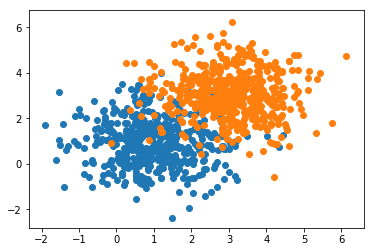

In [23]:
xy = gaussian_data(([1, 1], [3, 3]), (np.eye(2), np.eye(2)), 1000)
positive = xy[xy[:, 2] == 1]
negative = xy[xy[:, 2] == -1]
plt.scatter(positive[:, 0], positive[:, 1])
plt.scatter(negative[:, 0], negative[:, 1])
plt.show()

In [24]:
def w_dot_xmat(w, xmat):
    return np.dot(np.transpose(w), xmat)

In [25]:
def vector_hinge_loss(a, y):
    return np.maximum(0, 1 - y * a)

In [26]:
def primal_cum_loss(w, xmat, y, lamb, lossfunc=vector_hinge_loss):
    n = x_mat.shape[1]
    a = w_dot_xmat(w, xmat) 
    cumloss = (1 / n) * np.sum(loss_func(a, y))
    reg = (lamb / 2) * np.linalg.norm(w)
    return cumloss + reg

In [27]:
def alpha_to_w(alpha, xmat, lamb):
    n = x_mat.shape[1]
    return (1 / (n * lamb)) * np.dot(xmat, alpha)